In [1]:
import pymongo
MongoClient = pymongo.MongoClient
client = MongoClient()
from geopy.geocoders import Nominatim
import pandas as pd
import plotly as plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
db = client.companies

In [3]:
filterquery ={"$and":
    [
     {"$or":
        [
            {"category_code": "software"},
            {"category_code": "web"},
            {"category_code": "mobile"},
            {"category_code": "games_video"}
        ]},
      {"$and":
         [
             {"founded_year": {"$gt":2000}},
             {"$or":
              [
                 {"deadpooled_year":{"$eq": None}},
                 {"deadpooled_year":{"$exists":False}}
              ]
             }
         ]},
              {"$and":
       [
          {"relationships.title":{'$regex':'Software Engineer'}},
          {"$or":
             [
                 {"$or":
                     [
                         {"relationships.title":{'$regex':'[Dd]esigner'}},
                         {"relationships.title":{'$regex':'[Cc]reative'}},
                         {"relationships.title":{'$regex':'U[XI]'}},
                         {"relationships.title":{'$regex':'[Cc]reative'}},
                     ]},
                 {"relationships.title":{'$regex':'[Dd]evelopers'}},
                 {"$or":
                     [
                         {"relationships.title":{'$regex':'[Ee]xecutive'}},
                         {"relationships.title":{'$regex':'[Mm]anager'}}
                     ]} 
            ]
          }
       ]
      }
    ]
}

In [4]:
def filterData(cursor, clean=None):
    geoCompanies = list(map(lambda c: convertCompanies(c,clean),cursor))
    return geoCompanies
    
def toGeoJSON(array):
    coor=['','']
    for i in array:
        geolocator = Nominatim(user_agent="tableau-project")
        
        if not i['latitude'] or not i['longitude']:
            if i['address1'] != '' and i['city'] != '' and i['address1'] != None and i['city'] != None:
                location = geolocator.geocode(i['address1'])
                if location != None:
                    coor=[location.longitude,location.latitude]
            elif i['address1'] != '' and not i['address1']:
                location = geolocator.geocode(i['address1'])
                coor=[location.longitude,location.latitude]
        else:
            coor=[i['longitude'],i['latitude']]
    if coor != ['','']:
        return {
            "type":"Point",
            "coordinates":coor
        }

def convertCompanies(company,clean):
    if clean == None:
        result= {
            "name": company["name"],
            "homepage_url": company["homepage_url"],
            "number_of_employees": company["number_of_employees"],
            "total_money_raised": company["total_money_raised"],
            "category_code":company["category_code"],
            "position": toGeoJSON(company["offices"])
        }
    else:
        result= {
            "name": company["name"],
            "homepage_url": company["homepage_url"],
            "number_of_employees": company["number_of_employees"],
            "total_money_raised": company["total_money_raised"],
            "category_code":company["category_code"],
            "position": company["position"],
            "near_compoanies": near_companies(company)
        }
    return result

geoCompanies = filterData(db.companies.find(filterquery))

In [5]:
df = pd.DataFrame(geoCompanies)
df.to_json('clean_companies.json',orient="records", lines=True)

In [6]:
db_clean = client.clean_companies

In [7]:
def near_companies(array):
    if array['position'] != None:
        coord=array['position']['coordinates']
        value=db_clean.clean_companies.count({"$and":
    [
        {"position":{"$ne":None}},
        {
          "position": {
            "$near": {
              "$geometry": {
                "type": "Point",
                "coordinates": coord
              },
              "$minDistance": 0,
              "$maxDistance":2000
            }
          }
        }
    ]
  })
        return value
c_n_companies=filterData(db_clean.clean_companies.find({"position":{"$ne":None}}),"clean")

/home/luis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning:

count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere



In [8]:
df = pd.DataFrame(c_n_companies)
# display(df.head())

def dataframe_final(df):
    coords_df = pd.DataFrame(pd.DataFrame(df["position"].values.flatten().tolist())["coordinates"].values.tolist())
    clean_df = pd.concat([df,coords_df],axis=1)
    clean_df.drop("position", inplace=True, axis=1)
    clean_df = clean_df.rename({0:"long",1:"lat"}, axis=1)
    clean_df.drop_duplicates(subset =["category_code","name"], 
                         keep = False, inplace = True)
    clean_df.drop(clean_df[clean_df["near_compoanies"] < 4].index, inplace=True)
    clean_df.drop(clean_df[clean_df["total_money_raised"] == "$0"].index, inplace=True)
    geolocator = Nominatim(user_agent="tableau-project")
    city=[geolocator.reverse([clean_df.lat.values[i],clean_df.long.values[i]]).address.split(",")[-3] for i in range(len(clean_df.lat.values))]
    clean_df["city"]=city
    clean_df['total_money_raised']=clean_df['total_money_raised'].str.extract('(\d+\.?\d?)').astype(float)
    return clean_df
data_final=dataframe_final(df)
data_final

,category_code,homepage_url,name,near_compoanies,number_of_employees,total_money_raised,long,lat,city
3,web,http://seesmic.com,Seesmic,5,13.0,16.0,-122.419204,37.775196,California
10,games_video,http://ilike.com,iLike,4,28.0,16.5,-122.323408,47.615313,Washington
13,software,http://www.xobni.com,Xobni,13,0.0,41.8,-122.404052,37.789634,California
17,web,http://www.disqus.com,Disqus,12,43.0,10.5,-122.397672,37.786906,California
22,web,http://www.eventbrite.com,Eventbrite,13,200.0,140.0,-122.390710,37.779507,California
23,mobile,http://www.pelago.com,Pelago,4,NaN,22.4,-122.335373,47.607065,Washington
27,web,http://hubpages.com,HubPages,12,21.0,8.0,-122.399151,37.787695,California
31,games_video,http://www.zynga.com,Zynga,6,115.0,860.0,-122.404234,37.765158,California
33,software,http://www.doubletwist.com,doubleTwist,5,NaN,7.5,-122.419204,37.775196,California
35,games_video,http://www.playfirst.com,PlayFirst,12,NaN,37.7,-122.401850,37.790346,California


In [9]:
data_final.to_json('visualize_companies.json', orient="records")

In [10]:
def map_chart(df):
    mapbox_access_token = 'pk.eyJ1IjoibG1hcnRpbmV6cnVpeml0IiwiYSI6ImNqcnV2NTNycjE3ZnQzeXFzbHk3NXB5MjYifQ.Namsd_wjsdPevALwq2YTmQ'

    site_lat = df.lat
    site_lon = df.long
    locations_name = df.name

    df2 = [
        go.Scattermapbox(
            lat=site_lat,
            lon=site_lon,
            mode='markers',
            marker=dict(
                size=17,
                color='rgb(255, 0, 0)',
                opacity=0.7
            ),
            hoverinfo='text',
            text=locations_name
            
        ),
        go.Scattermapbox(
            lat=site_lat,
            lon=site_lon,
            mode='markers',
            marker=dict(
                size=8,
                color='rgb(242, 177, 172)',
                opacity=0.7
            ),

            hovertext=locations_name+":: url: "+df.homepage_url,
        )]
            
    layout = go.Layout(
        title='Companies',
        autosize=True,
        hovermode='closest',
        showlegend=False,
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=38,
                lon=-94
            ),
            pitch=0,
            zoom=3,
            style='light'
        ),
    )
    fig = dict(data=df2, layout=layout)
    plotly.offline.plot(fig, filename='Companies' )
map_chart(data_final)

/home/luis/anaconda3/lib/python3.7/site-packages/plotly/offline/offline.py:635: UserWarning:

Your filename `Companies` didn't end with .html. Adding .html to the end of your file.



Text(0.5, 0, 'City')

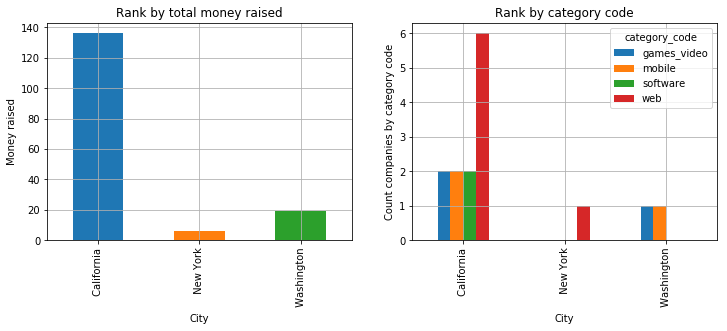

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
data_final.groupby(['city'])['total_money_raised'].mean().plot.bar(ax=ax1).grid()
ax1.set_title('Rank by total money raised')
ax1.set_ylabel('Money raised')
ax1.set_xlabel('City')

#2
data_final.groupby(['city','category_code'])['name'].count().unstack('category_code').plot.bar(ax=ax2).grid()
ax2.set_title('Rank by category code')
ax2.set_ylabel('Count companies by category code')
ax2.set_xlabel('City')